In [7]:
#region imports
import pandas as pd
import numpy as np
import missingno as msno
import random
import re
from nltk import word_tokenize
import re
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
stop_words = nltk.corpus.stopwords.words("english")
lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import CountVectorizer


RANDOMSEED = 100
DISPLAY_WIDTH = 400
DISPLAYMAX_COLUMNS = 25
#endregion

#region settings
random.seed(RANDOMSEED)
pd.set_option('display.width', DISPLAY_WIDTH)
pd.set_option('display.max_columns', DISPLAYMAX_COLUMNS)
#endregion

In [8]:
df_awards=pd.read_csv("../data/220k_awards_by_directors.csv")
df_500_fav=pd.read_csv("../data/500 favorite directors_with wikipedia summary.csv", sep=";",header=0,names=['A', 'B'])
df_900_acc=pd.read_csv("../data/900_acclaimed_directors_awards.csv", sep=";")
df_all_casting=pd.read_csv("../data/AllMoviesCastingRaw.csv", sep=";")
df_all_details = pd.read_csv("../data/AllMoviesDetailsCleaned.csv", sep=";",low_memory=False)
df_lan2country_df = pd.read_csv('../data/language to country.csv')
df_most_common_lang=pd.read_csv("../data/MostCommonLanguageByDirector.csv")
df_spliberg=pd.read_csv("../data/spielberg_awards.csv",encoding='latin1')

In [9]:
def show(df_, rows=20, cols=30, title=None):
    if title:
        display(HTML(f'<h2 >{title}</h2 > '))
        with pd.option_context('display.min_rows', rows, 'display.max_columns', cols):
            display(df_)
    return df_

def get_var(df, var_name):
    globals()[var_name] = df
    return df

def tokenize(text):
    '''this method does the following
    1. normalizing all the words to lower size
    2. removes punctuations
    3. splits the words
    4. removes the stopwords like am,is,have,you,...
    5. lammetizes the words for example running-->run
    '''
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())    # normalize case and remove punctuation
    tokens = word_tokenize(text)    # tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]    # lemmatize andremove stop words
    return tokens

def prep_data(text,method=CountVectorizer):
    '''
    this method counts either counts the words 
    in sentences (CountVectorizer) or wights them 
    based on their importance in the sentence 
    and entire data(TfidfVectorizer):
    '''
    count_vector = method(tokenizer=tokenize)
    count_vector.fit(text)
    doc_array = count_vector.transform(text).toarray()
    frequency_matrix_count = pd.DataFrame(doc_array, columns=count_vector.get_feature_names_out())
    return frequency_matrix_count

In [10]:
df=(df_all_details
    
    .query("status in ['Released']")
    .pipe(lambda df_:df_.replace("none",np.NaN))
    .assign(revenue=lambda df_:df_.revenue.replace(0,np.NAN),
        genres=lambda df_:df_.genres.fillna("none"),
        runtime=lambda df_:df_.runtime.fillna(-999),
        original_language=lambda df_:df_.original_language.fillna("none"),
        year=lambda df_:(2025-pd.to_datetime(df_.release_date,dayfirst=True).dt.year).fillna(-999),
        month=lambda df_:(pd.to_datetime(df_.release_date,dayfirst=True).dt.month),
        sin_month=lambda df_:(np.sin(2*np.pi*(df_.month-1)/12)).fillna(-999),
        cos_month=lambda df_:(np.cos(2*np.pi*(df_.month-1)/12)).fillna(-999),
        
        )
    .dropna(subset="revenue")
    .reset_index(drop=True)
    .pipe(lambda df_:pd.concat([df_,
                              prep_data(df_.genres)],axis=1))
    .drop(columns=["budget","imdb_id","original_title",
                   "overview","popularity","status","tagline","title","vote_average","vote_count",
                   "production_companies",	"production_countries","month","spoken_languages","release_date"])
    
)
df

/home/ashamsa/.pyenv/versions/.pde_cap/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:524: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,id,genres,original_language,revenue,runtime,production_companies_number,production_countries_number,spoken_languages_number,year,sin_month,cos_month,action,...,history,horror,movie,music,mystery,none,romance,science,thriller,tv,war,western
0,5,Crime|Comedy,en,4300000.0,98.0,2,1,1,30.0,-5.000000e-01,8.660254e-01,0,...,0,0,0,0,0,0,0,0,0,0,0,0
1,6,Action|Thriller|Crime,en,12136938.0,110.0,3,2,1,32.0,-1.000000e+00,-1.836970e-16,1,...,0,0,0,0,0,0,0,0,1,0,0,0
2,11,Adventure|Action|Science Fiction,en,775398007.0,121.0,2,1,1,48.0,8.660254e-01,-5.000000e-01,1,...,0,0,0,0,0,0,0,1,0,0,0,0
3,12,Animation|Family,en,940335536.0,100.0,1,1,1,22.0,8.660254e-01,-5.000000e-01,0,...,0,0,0,0,0,0,0,0,0,0,0,0
4,13,Comedy|Drama|Romance,en,677945399.0,142.0,1,1,1,31.0,1.224647e-16,-1.000000e+00,0,...,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8653,468517,Documentary,es,200.0,-999.0,1,1,1,8.0,5.000000e-01,-8.660254e-01,0,...,0,0,0,0,0,0,0,0,0,0,0,0
8654,468579,Drama|Fantasy,en,700.0,10.0,1,3,0,9.0,5.000000e-01,-8.660254e-01,0,...,0,0,0,0,0,0,0,0,0,0,0,0
8655,468654,none,ar,40000.0,-999.0,0,1,1,-999.0,-9.990000e+02,-9.990000e+02,0,...,0,0,0,0,0,1,0,0,0,0,0,0
8656,468656,Action|Adventure|Animation|Comedy|Crime|Family...,ur,640691.0,108.0,3,1,1,9.0,-5.000000e-01,8.660254e-01,1,...,0,0,0,0,0,0,0,1,0,0,0,0


<AxesSubplot:>

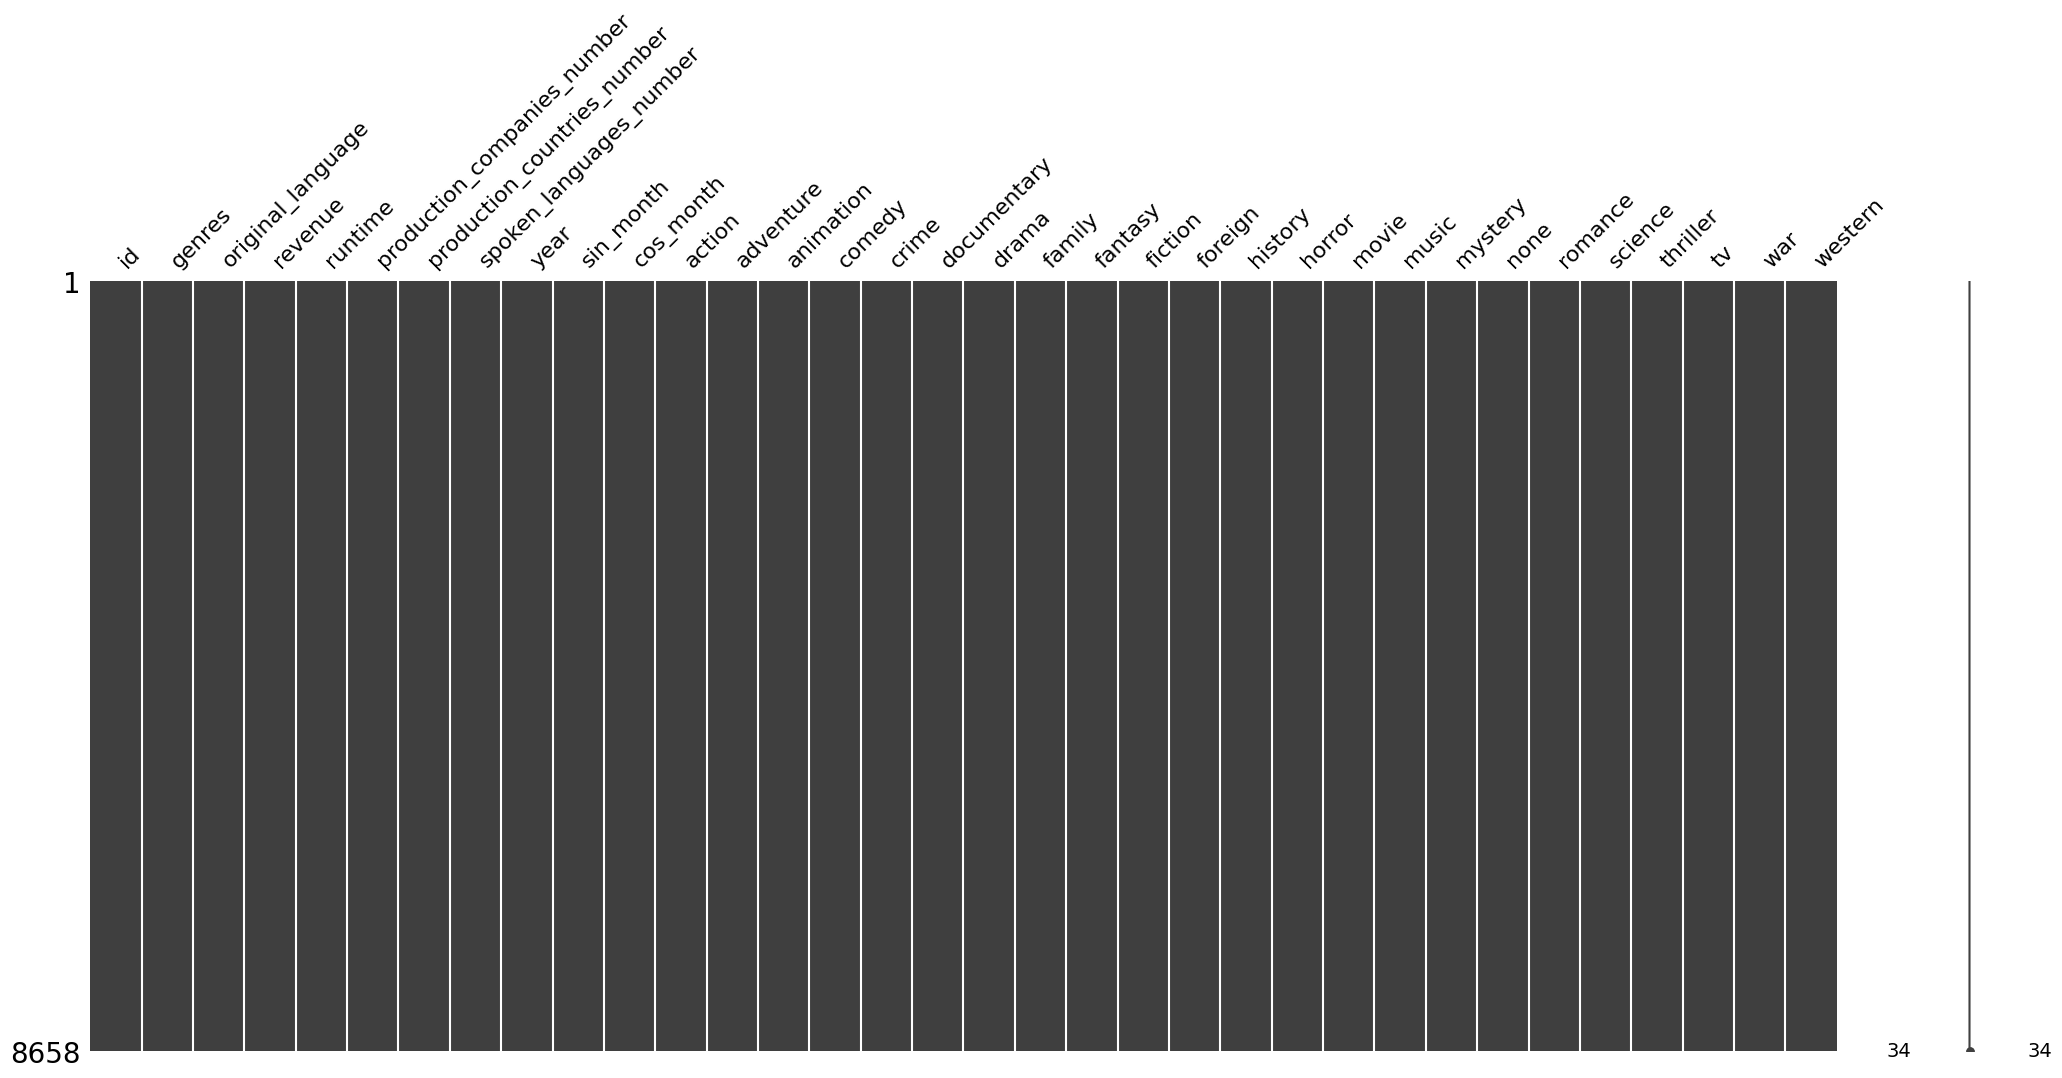

In [11]:
msno.matrix(df)